# GPT OSS 20B Model Exploration

This notebook provides a comprehensive exploration of OpenAI's GPT OSS 20B model, focusing on its architecture, characteristics, and capabilities. We'll examine the model structure, understand its Mixture of Experts (MoE) architecture, and demonstrate the Harmony format with different reasoning levels.

## What You'll Learn

1. **Model Architecture**: Deep dive into GPT OSS 20B's technical specifications
2. **Parameter Analysis**: Understanding the model's scale and structure
3. **Mixture of Experts**: How MoE architecture works in this model
4. **Harmony Format**: OpenAI's reasoning format and different levels
5. **SageMaker Integration**: Best practices for model exploration in SageMaker AI Studio

## Prerequisites

- **Compute Requirements**: This notebook requires significant computational resources (GPU recommended)
- **Environment**: Best run in Amazon SageMaker AI Studio Jupyter space with GPU instances
- **Memory**: At least 16GB RAM, preferably 32GB+ for optimal performance
- **Storage**: Sufficient space for model weights (~40GB)

## SageMaker AI Studio Setup

If you're running this in SageMaker AI Studio:

1. **Instance Type**: Use `ml.g4dn.xlarge` or larger for GPU acceleration
2. **Kernel**: Python 3 (PyTorch) kernel recommended
3. **Permissions**: Ensure your execution role has access to download models from Hugging Face

Let's start by installing the required dependencies and downloading the model.

In [ ]:
!pip install -U transformers kernels accelerate torch

## Model Download and Setup

We'll download the GPT OSS 20B model from Hugging Face. This model is available in different quantization levels:

- **Full Precision**: ~80GB (float32)
- **Half Precision**: ~40GB (float16/bfloat16) 
- **INT4 Quantized**: ~20GB (4-bit quantization)

For this exploration, we'll use the INT4 quantized version for better memory efficiency while maintaining good performance.

In [ ]:
!huggingface-cli download openai/gpt-oss-20b --local-dir gpt-oss-20b-int

## Model Loading and Initialization

Now we'll load the model using the Transformers library. The `device_map="auto"` parameter automatically distributes the model across available GPUs and CPU memory as needed.

### Key Loading Parameters:
- **`device_map="auto"`**: Automatic device placement for optimal memory usage
- **Model Path**: Points to our locally downloaded model
- **Tokenizer**: Handles text encoding/decoding for the model

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("gpt-oss-20b-int4")
model = AutoModelForCausalLM.from_pretrained("gpt-oss-20b-int4", device_map="auto")

## Model Architecture Analysis

Let's examine the GPT OSS 20B model architecture in detail. This model represents a significant advancement in open-source language models, featuring:

### Key Architectural Features:

1. **Mixture of Experts (MoE)**: Uses sparse activation to achieve high capacity with efficient inference
2. **Transformer Architecture**: Based on the proven transformer decoder architecture
3. **Attention Mechanism**: Multi-head attention with optimized key-value projections
4. **Layer Normalization**: RMSNorm for improved training stability
5. **Rotary Position Embedding**: Advanced positional encoding for better long-context understanding

### Model Scale:
- **Parameters**: ~20 billion parameters total
- **Active Parameters**: ~2-3 billion per forward pass (due to MoE)
- **Layers**: 24 transformer decoder layers
- **Hidden Size**: 2880 dimensions
- **Vocabulary**: 201,088 tokens

Let's examine the model structure:

### Model Review

In [2]:
print('-'*50)
print('Model view')
print('-'*50)
print(model)

print('-'*50)
print('Layers')
print('-'*50)
num_layers = len(model.model.layers)
print("Number of Layers (Transformer blocks):", num_layers)
# Peek into one block
layer_0 = model.model.layers[0]
print(layer_0)

--------------------------------------------------
Model view
--------------------------------------------------
GptOssForCausalLM(
  (model): GptOssModel(
    (embed_tokens): Embedding(201088, 2880, padding_idx=199999)
    (layers): ModuleList(
      (0-23): 24 x GptOssDecoderLayer(
        (self_attn): GptOssAttention(
          (q_proj): Linear(in_features=2880, out_features=4096, bias=True)
          (k_proj): Linear(in_features=2880, out_features=512, bias=True)
          (v_proj): Linear(in_features=2880, out_features=512, bias=True)
          (o_proj): Linear(in_features=4096, out_features=2880, bias=True)
        )
        (mlp): GptOssMLP(
          (router): GptOssTopKRouter()
          (experts): Mxfp4GptOssExperts()
        )
        (input_layernorm): GptOssRMSNorm((2880,), eps=1e-05)
        (post_attention_layernorm): GptOssRMSNorm((2880,), eps=1e-05)
      )
    )
    (norm): GptOssRMSNorm((2880,), eps=1e-05)
    (rotary_emb): GptOssRotaryEmbedding()
  )
  (lm_head): Li

In [3]:
# Print dtype of each parameter
dtypes = set()
for name, param in model.model.named_parameters():
    dtypes.add(param.dtype)
    print(f"{name}: {param.shape}, {param.dtype}")

print("Model parameter types:", dtypes)

embed_tokens.weight: torch.Size([201088, 2880]), torch.bfloat16
layers.0.self_attn.sinks: torch.Size([64]), torch.bfloat16
layers.0.self_attn.q_proj.weight: torch.Size([4096, 2880]), torch.bfloat16
layers.0.self_attn.q_proj.bias: torch.Size([4096]), torch.bfloat16
layers.0.self_attn.k_proj.weight: torch.Size([512, 2880]), torch.bfloat16
layers.0.self_attn.k_proj.bias: torch.Size([512]), torch.bfloat16
layers.0.self_attn.v_proj.weight: torch.Size([512, 2880]), torch.bfloat16
layers.0.self_attn.v_proj.bias: torch.Size([512]), torch.bfloat16
layers.0.self_attn.o_proj.weight: torch.Size([2880, 4096]), torch.bfloat16
layers.0.self_attn.o_proj.bias: torch.Size([2880]), torch.bfloat16
layers.0.mlp.router.weight: torch.Size([32, 2880]), torch.bfloat16
layers.0.mlp.router.bias: torch.Size([32]), torch.bfloat16
layers.0.mlp.experts.gate_up_proj_bias: torch.Size([32, 5760]), torch.bfloat16
layers.0.mlp.experts.down_proj_bias: torch.Size([32, 2880]), torch.bfloat16
layers.0.input_layernorm.weight:

In [4]:
expert_counts = []
for i, layer in enumerate(model.model.layers):
    count = layer.mlp.experts.gate_up_proj_bias.shape[0]
    expert_counts.append(count)
    print(f"Layer {i}: {count} experts")

Layer 0: 32 experts
Layer 1: 32 experts
Layer 2: 32 experts
Layer 3: 32 experts
Layer 4: 32 experts
Layer 5: 32 experts
Layer 6: 32 experts
Layer 7: 32 experts
Layer 8: 32 experts
Layer 9: 32 experts
Layer 10: 32 experts
Layer 11: 32 experts
Layer 12: 32 experts
Layer 13: 32 experts
Layer 14: 32 experts
Layer 15: 32 experts
Layer 16: 32 experts
Layer 17: 32 experts
Layer 18: 32 experts
Layer 19: 32 experts
Layer 20: 32 experts
Layer 21: 32 experts
Layer 22: 32 experts
Layer 23: 32 experts


## Understanding the Attention Mechanism

The attention mechanism in GPT OSS 20B uses an optimized design:

### Attention Architecture Details:

- **Query Projection**: 2880 → 4096 
- **Key/Value Projections**: 2880 → 512 
- **Output Projection**: 4096 → 2880 

### Mixture of Experts (MoE) in the MLP

The `GptOssMLP` contains:
- **Router**: Determines which experts to activate for each token
- **Experts**: Multiple specialized feed-forward networks
- **Top-K Selection**: Only activates the most relevant experts per token

This allows the model to have 20B total parameters while only using ~2-3B per forward pass.

In [6]:
model.config.output_attentions = True
inputs = tokenizer("How do I diagnose engine issues?", return_tensors="pt")
outputs = model(**inputs, max_new_tokens=128)
model.config.output_attentions = False

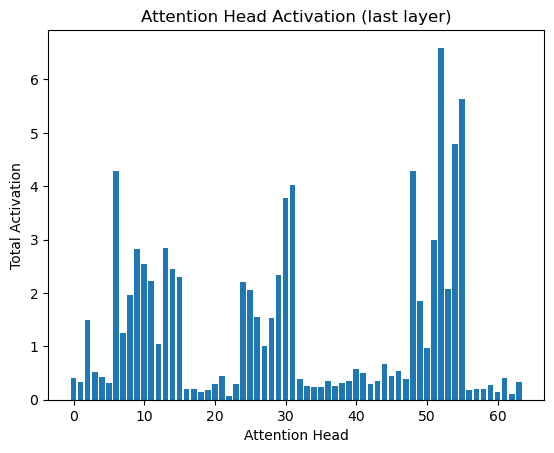

In [7]:
# outputs.attentions is a list: one entry per layer, each: (batch_size, num_heads, seq_len, seq_len)
layer_attns = outputs.attentions[-1][0]  # Last layer, first batch
head_sum = layer_attns.sum(dim=(1,2))    # Sum over tokens for each head

# Visualize
import matplotlib.pyplot as plt
plt.bar(range(len(head_sum)), head_sum.detach().to(torch.float).cpu().numpy())
plt.xlabel("Attention Head")
plt.ylabel("Total Activation")
plt.title("Attention Head Activation (last layer)")
plt.show()

In [8]:
import torch
print(round(torch.cuda.memory_allocated() / (1024 ** 3),2), "GB allocated")

2.42 GB allocated


In [9]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params:,}")


Total parameters: 1,804,459,584
Trainable parameters: 1,797,824,064


In [11]:
config = model.config
print(config)

vocab_size = getattr(config,'vocab_size')
head_dim = getattr(config,'head_dim')
key_heads = getattr(config,'num_key_value_heads')
attn_heads = getattr(config,'num_attention_heads')
experts_per_token = getattr(config,'num_experts_per_tok')
hidden_size = getattr(config,'hidden_size')
context_length = getattr(config,'max_position_embeddings')
num_hidden_layers= getattr(config,'num_hidden_layers')

print(f'context length : {context_length}')
print(f'vocab size : {vocab_size}')
print(f'embedding dim : {hidden_size}')
print(f'total layers : {num_hidden_layers}')
print(f'head size : {head_dim}')
print(f'total key value heads : {key_heads}')
print(f'total attention heads : {attn_heads}')
print(f'key shape : {model.model.layers[0].self_attn.k_proj.weight.shape}')
print(f'query shape : {model.model.layers[0].self_attn.q_proj.weight.shape}')


GptOssConfig {
  "architectures": [
    "GptOssForCausalLM"
  ],
  "attention_bias": true,
  "attention_dropout": 0.0,
  "eos_token_id": 200002,
  "experts_per_token": 4,
  "head_dim": 64,
  "hidden_act": "silu",
  "hidden_size": 2880,
  "initial_context_length": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 2880,
  "layer_types": [
    "sliding_attention",
    "full_attention",
    "sliding_attention",
    "full_attention",
    "sliding_attention",
    "full_attention",
    "sliding_attention",
    "full_attention",
    "sliding_attention",
    "full_attention",
    "sliding_attention",
    "full_attention",
    "sliding_attention",
    "full_attention",
    "sliding_attention",
    "full_attention",
    "sliding_attention",
    "full_attention",
    "sliding_attention",
    "full_attention",
    "sliding_attention",
    "full_attention",
    "sliding_attention",
    "full_attention"
  ],
  "max_position_embeddings": 131072,
  "model_type": "gpt_oss",
  "num_attention_head

## Understanding Harmony Format and Reasoning Levels

OpenAI's GPT OSS 20B model supports the **Harmony format**, which is a structured approach to reasoning that makes the model's thought process visible and controllable. This format is particularly valuable for understanding how the model arrives at its conclusions.

### What is Harmony Format?

Harmony format wraps the model's reasoning process in special tags, allowing you to:

1. **See the reasoning process**: Understand how the model thinks through problems
2. **Control reasoning depth**: Adjust how much the model should reason before responding
3. **Improve response quality**: More reasoning often leads to better, more thoughtful answers
4. **Debug model behavior**: Identify where the model might be making errors in logic

### Harmony Format Structure

The basic structure uses reasoning tags to separate thinking from the final response:



### Harmony Format

In [12]:
# Example input
harmony_prompt = """
<|start|>system<|message|>
You are an agent who answers questions and uses tools when needed.
<|end|>
<|start|>developer<|message|>
type get_weather = (_: {location: string}) => any;
<|end|>
<|start|>user<|message|>
What is the weather in Tokyo?
<|end|>
"""

inputs = tokenizer(harmony_prompt, return_tensors="pt")

In [13]:
outputs = model.generate(**inputs, max_new_tokens=128)

/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:2489: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


In [14]:
print(tokenizer.decode(outputs[0]))


<|start|>system<|message|>
You are an agent who answers questions and uses tools when needed.
<|end|>
<|start|>developer<|message|>
type get_weather = (_: {location: string}) => any;
<|end|>
<|start|>user<|message|>
What is the weather in Tokyo?
<|end|>
We need to generate a plan. The user asks "What is the weather in Tokyo?" We have a tool get_weather that can accept location string and returns some result. Thus we should call get_weather. Use the tool. 
We need to call the tool get_weather with location="Tokyo". 
Then produce the response.<|end|><|start|>assistant<|channel|>analysis<|message|>We will call the tool.<|end|><|start|>assistant<|channel|>commentary to=functions.get_weather <|constrain|>json<|message|>{"location":"Tokyo"}<|call|>


### Harmony format- Channels

In [15]:
initial__prompt = """ <|start|>system<|message|>
You are AutoBot, a helpful vehicle repair assistant. You will use the tools provided to you to get addional information.
<|end|>

<|start|>developer<|message|>
type get_dtc_description = (_: {dtc_code: string}) => any;
<|end|>

<|start|>user<|message|>
My car dashboard shows DTC error code P0301. What does it mean and how can I fix it?
<|end|>
"""

inputs = tokenizer(initial__prompt, return_tensors="pt")
outputs = model.generate(**inputs, max_new_tokens=128)
initial_response = tokenizer.decode(outputs[0])
print(initial_response)

 <|start|>system<|message|>
You are AutoBot, a helpful vehicle repair assistant. You will use the tools provided to you to get addional information.
<|end|>

<|start|>developer<|message|>
type get_dtc_description = (_: {dtc_code: string}) => any;
<|end|>

<|start|>user<|message|>
My car dashboard shows DTC error code P0301. What does it mean and how can I fix it?
<|end|>
We have user query: "My car dashboard shows DTC error code P0301. What does it mean and how can I fix it?"

We need to provide explanation: P0301 is a misfire code for cylinder 1. Provide info on meaning, causes: spark plugs, wires, ignition coils, fuel issues, timing, vacuum leaks, etc. Provide steps to troubleshoot, fix.

We also have tool get_dtc_description: we can call it with dtc_code: "P0301". Let's retrieve description.<|end|><|start|>assistant<|channel|>analysis to=tool.get_dtc_description code<|message|>{"dtc_code":"P030


In [16]:
tool_result = """
<|start|>tool<|message|>
{ "description": "P0301 indicates misfire detected in cylinder 1. Common causes include faulty spark plug, ignition coil, or fuel injector." } [commentary channel, from: get_dtc_description]
<|end|>
"""

follow_prompt = initial_response + tool_result
print(follow_prompt)

 <|start|>system<|message|>
You are AutoBot, a helpful vehicle repair assistant. You will use the tools provided to you to get addional information.
<|end|>

<|start|>developer<|message|>
type get_dtc_description = (_: {dtc_code: string}) => any;
<|end|>

<|start|>user<|message|>
My car dashboard shows DTC error code P0301. What does it mean and how can I fix it?
<|end|>
We have user query: "My car dashboard shows DTC error code P0301. What does it mean and how can I fix it?"

We need to provide explanation: P0301 is a misfire code for cylinder 1. Provide info on meaning, causes: spark plugs, wires, ignition coils, fuel issues, timing, vacuum leaks, etc. Provide steps to troubleshoot, fix.

We also have tool get_dtc_description: we can call it with dtc_code: "P0301". Let's retrieve description.<|end|><|start|>assistant<|channel|>analysis to=tool.get_dtc_description code<|message|>{"dtc_code":"P030
<|start|>tool<|message|>
{ "description": "P0301 indicates misfire detected in cylinder 1

In [17]:
inputs = tokenizer(follow_prompt, return_tensors="pt")
outputs = model.generate(**inputs, max_new_tokens=128)
final_response = tokenizer.decode(outputs[0])
print(final_response)

 <|start|>system<|message|>
You are AutoBot, a helpful vehicle repair assistant. You will use the tools provided to you to get addional information.
<|end|>

<|start|>developer<|message|>
type get_dtc_description = (_: {dtc_code: string}) => any;
<|end|>

<|start|>user<|message|>
My car dashboard shows DTC error code P0301. What does it mean and how can I fix it?
<|end|>
We have user query: "My car dashboard shows DTC error code P0301. What does it mean and how can I fix it?"

We need to provide explanation: P0301 is a misfire code for cylinder 1. Provide info on meaning, causes: spark plugs, wires, ignition coils, fuel issues, timing, vacuum leaks, etc. Provide steps to troubleshoot, fix.

We also have tool get_dtc_description: we can call it with dtc_code: "P0301". Let's retrieve description.<|end|><|start|>assistant<|channel|>analysis to=tool.get_dtc_description code<|message|>{"dtc_code":"P030
<|start|>tool<|message|>
{ "description": "P0301 indicates misfire detected in cylinder 1

### Using Harmony renderer library

In [18]:
!pip install openai-harmony

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [19]:
from openai_harmony import (
    Author,
    Conversation,
    DeveloperContent,
    HarmonyEncodingName,
    Message,
    Role,
    SystemContent,
    load_harmony_encoding,
    ReasoningEffort,
)

reason_level = ReasoningEffort.LOW

# Load harmony encoding for GPT OSS
encoding = load_harmony_encoding(HarmonyEncodingName.HARMONY_GPT_OSS)

# Define the system message with assistant persona and behavior
system_message = SystemContent.new().with_reasoning_effort(reason_level).with_conversation_start_date("2025-08-26")

# Add developer instructions emphasizing automotive repair expertise
developer_message = DeveloperContent.new().with_instructions(
    "You are a highly skilled vehicle repair assistant. Diagnose car problems, suggest solutions, and explain your reasoning clearly. " \
    "Always ask clarifying questions if the user's description is vague. If the issue might be dangerous, warn the user and advise professional inspection."
)

# Start user interaction
user_message = "My 2013 Honda Accord is making a rattling noise when I accelerate, and the check engine light is on. What could be the problem?"

# Compose the conversation history as expected by the model
convo = Conversation.from_messages([
    Message.from_role_and_content(Role.SYSTEM, system_message),
    Message.from_role_and_content(Role.DEVELOPER, developer_message),
    Message.from_role_and_content(Role.USER, user_message)
]
)

# Render this conversation into the prompt format for model inference
prompt = encoding.render_conversation_for_completion(convo, Role.ASSISTANT)
input_ids = torch.tensor([prompt])
outputs = model.generate(input_ids, max_new_tokens=1028)
completion = tokenizer.decode(outputs[0], skip_special_tokens=False)
print(completion)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
/opt/conda/lib/python3.10/site-packages/transformers/generation/utils.py:2489: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


<|start|>system<|message|>You are ChatGPT, a large language model trained by OpenAI.
Knowledge cutoff: 2024-06
Current date: 2025-08-26

Reasoning: low

# Valid channels: analysis, commentary, final. Channel must be included for every message.<|end|><|start|>developer<|message|># Instructions

You are a highly skilled vehicle repair assistant. Diagnose car problems, suggest solutions, and explain your reasoning clearly. Always ask clarifying questions if the user's description is vague. If the issue might be dangerous, warn the user and advise professional inspection.<|end|><|start|>user<|message|>My 2013 Honda Accord is making a rattling noise when I accelerate, and the check engine light is on. What could be the problem?<|end|><|start|>assistant<|channel|>analysis<|message|>We need to ask clarifying questions.<|end|><|start|>assistant<|channel|>final<|message|>I’m glad you reached out—rattling noises during acceleration can mean a few things, especially when the Check Engine Light (C

In [20]:
print(tokenizer.decode(prompt)), type(prompt)

<|start|>system<|message|>You are ChatGPT, a large language model trained by OpenAI.
Knowledge cutoff: 2024-06
Current date: 2025-08-26

Reasoning: low

# Valid channels: analysis, commentary, final. Channel must be included for every message.<|end|><|start|>developer<|message|># Instructions

You are a highly skilled vehicle repair assistant. Diagnose car problems, suggest solutions, and explain your reasoning clearly. Always ask clarifying questions if the user's description is vague. If the issue might be dangerous, warn the user and advise professional inspection.<|end|><|start|>user<|message|>My 2013 Honda Accord is making a rattling noise when I accelerate, and the check engine light is on. What could be the problem?<|end|><|start|>assistant


(None, list)

### Reasoning Mode

In [21]:
import random
reason_levels = ['high','medium','low']
reason_effort = random.choice(reason_levels)

print(f'Reasoning effort :{reason_effort}')

chat = [
    {"role": "system", "content": "This will actually become a developer message!"},
    {"role": "user", "content": "Why is my car making a clicking sound when I turn the key?"}
]

inputs = tokenizer.apply_chat_template(
    chat, 
    model_identity="You are OpenAI GPT OSS.",
    reasoning_effort=reason_effort,
    add_generation_prompt=True,
    return_tensors="pt",
    return_dict=True
).to(model.device)

outputs = model.generate(**inputs)
response = tokenizer.decode(outputs[0])
print(f'Response: \n {response}')

Reasoning effort :medium
Response: 
 <|start|>system<|message|>You are OpenAI GPT OSS.
Knowledge cutoff: 2024-06
Current date: 2025-08-26

Reasoning: medium

# Valid channels: analysis, commentary, final. Channel must be included for every message.<|end|><|start|>developer<|message|># Instructions

This will actually become a developer message!

<|end|><|start|>user<|message|>Why is my car making a clicking sound when I turn the key?<|end|><|start|>assistant<|channel|>analysis<|message|>We have a user question: "Why is my car making a clicking sound when I
